# Avaliação 2 da disciplina Álgebra Linear Computacional

* Turma 01 - 2022.1 - Universidade Federal de Sergipe
* Professor: Evilson da Silva Vieira

Membros do grupo - Matrícula:

* Pedro Vinícius de Araújo Barreto - 202100011815

## Introdução

A Álgebra Linear Computacional tem aplicações em vários cenários de importância científica. Aqui, buscamos construir um perceptron que, a partir de imagens de treinamento, possa classificar imagens não vistas anteriormente como tratando-se de um homem ou uma mulher. 

Para isso, fazemos uso das seguintes técnicas:

* Fatoração QR <br>
* Método dos Mínimos Quadrados <br>
* Decomposição em Valores Singulares

## Carregamento dos dados

Importaremos o dataset que consiste de 200 imagens cinzas de homens e mulheres sérios ou sorrindo. Após movermos essas imagens para um diretório dedicado, precisamos converter essas imagens em informação numérica.

Cada imagem pode ser vista como um array de $193 * 162$ inteiros de 0 a 255. A partir disso, montaremos uma matriz de $A_{200 \times 31266}$.

Para ler uma imagem como uma array, usaremos a função `skimage.io`, que permite o Input/Output de imagens como arrays numéricas. Para lidar com arrays e matrizes de maneira geral, usaremos a biblioteca `numpy`.

In [ ]:
# Primeiro importamos os dados/imagens e movemos para um diretório dedicado
!ls imagens || wget https://fei.edu.br/~cet/frontalimages_spatiallynormalized_cropped_equalized_part1.zip
!mkdir imagens && unzip frontalimages_spatiallynormalized_cropped_equalized_part1.zip
!rm frontalimages_spatiallynormalized_cropped_equalized_part1.zip && mv *.jpg imagens

In [ ]:
# Bibliotecas
import numpy as np
import numpy.linalg as la
from skimage import io
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [ ]:
# Matriz que conterá as imagens
A = np.zeros(shape=(200, 193*162), dtype='uint8')

In [ ]:
# Lemos cada imagem no diretório e colocamos nas linhas de A
for i in range(1, 101):
    col = i*2 - 1
    A[col - 1, :] = io.imread(f'./imagens/{i}a.jpg').reshape(-1)
    A[col, :] = io.imread(f'./imagens/{i}b.jpg').reshape(-1)

A.shape

(200, 31266)

## Redução de dimensionalidade para uma matriz $200 \times 2$ usando SVD truncado

Lembremos que a decomposição SVD de uma matriz se trata de decompor ela como um produto das matrizes: 
- $V$, que é a matriz de mudança de base da base $γ_1$ de autovetores (que é ortonormal) para a base canônica;
- $S$, que é uma matriz que contêm até o $r$-ésimo valor singular de A em sua diagonal, e o resto são zeros. Veja que aqui $r$ é o posto de $A$;
- $U^t$, que é uma matriz de mudança de base da canônica para a base $γ_2$ de autovetores, que é ortonormal também.

Se $VSU^t$ é a decomposição SVD de $A$, podemos fazer uma decomposição truncada :
$$
A_2 = V_2 \cdot S_2
$$

na qual $V_2$ são as 2 primeiras colunas de $V$ e $S_2$ são as primeiras 
2 linhas e 2 colunas de $S$ (Ou seja, conterá os dois primeiros valores singulares $σ_1$ e $σ_2$).

Essa decomposição truncada é obtida usando a classe `sklearn.decomposition.TruncatedSVD`.

In [ ]:
svd = TruncatedSVD(n_components=2)
A_2 = svd.fit_transform(A)
A_2.shape

(200, 2)

Para relizar o treinamento do nosso perceptron, precisamos alimentá-lo com dados de treinamento para que assim possa ocorre algum aprendizado. Foi orientado pelo professor a escolher 40 das 200 imagens inicialmente disponibilizadas.

Resolvemos escolher de maneira igualitária 20 imagens de homens e 20 de mulheres. Como o dataset contém 100 indivíduos, e para cada indivíduo existe uma foto "séria" e outra foto sorrindo, escolhemos 10 indivíduos de cada sexo.

In [ ]:
# Escolher 10 homens e 10 mulheres para treinamento 
indice_homens = [0, 1, 4, 5, 10, 11, 16, 17, 18, 19, 112, 113, 102, 103, 74, 75, 140, 141, 188, 189]
indice_mulheres = [20, 21, 192, 193, 190, 191, 100, 101, 118, 119, 114, 115, 72, 73, 84, 85, 154, 155, 54, 55]

# H_t contém 20 imagens de homens, M_t contém 20 imagens de mulher
H_t = A_2[indice_homens, :]
M_t = A_2[indice_mulheres, :]

indices_deletar = indice_homens + indice_mulheres

In [ ]:
# Deletar os dados que foram obtidos para treinamento da matriz original
# A_2 agora tem 160 imagens. Ou seja, dados não vistos anteriormente!
A_2 = np.delete(A_2, indices_deletar, 0)
A_2.shape

(160, 2)

## Método dos Mínimos Quadrados junto com a fatoração QR

Agora que conseguimos realizar uma redução de dimensionalidade sobre A, buscaremos construir um sistema da forma $T \cdot x = C$, onde:

* $T_{40 × 3}$ é uma matriz contendo os 40 dados selecionados para treinamento. As 20 primeiras linhas são homens e as 20 últimas são mulheres ;
* $x_{3 \times 1}$ é uma matriz que contém os coeficientes $a$, $b$ e $c$ ;
* $C_{40 × 1}$ é uma matriz correspondendo a -1 para as 20 primeiras linhas (homens) e 1 para as 20 últimas (mulheres).

Após a construção desse sistema, queremos achar os melhores coeficientes
$a$, $b$ e $c$ para a função $f$ tais que:
$$
f(x, y) = ax + by + c
$$
e $f(x, y) = -1$ se $x$ e $y$ forem dados da imagem de um homem e $f(x, y) = 1$ caso forem dados da imagem de uma mulher.

Esse sistema, em seu estado atual, não tem solução. Buscaremos achar uma solução ótima.

In [ ]:
# Uma matriz 40x1 que representa o bias/viés
B = np.ones(shape=(40, 1), dtype='uint8')

# Unificamos H_t e M_t numa matriz de treinamento T
T = np.vstack([H_t, M_t])
T = np.hstack([T, B])

# Associamos cada linha da matriz de treinamento T com -1 (homens) ou 1 (mulheres)
C = np.zeros(shape=(40, 1))
C[:20, :] = -1
C[20:40, :] = 1

Aplicamos o método dos mínimos quadrados em conjunto com a fatoração QR para obter uma solução otimizada pro sistema.

Vimos em aula que num sistema $A \cdot x = b$, a solução pelos mínimos quadrados pode ser obtido ao multiplicar a equação à esquerda pela transposta de $A$: 
$$
A^t \cdot A \cdot x = A^t \cdot b
$$
Se fatorarmos $A_{}$ como produto de uma matriz $Q_{m \times n}$ ortonormal e uma matriz de mudança de base da base de $Q$ para a base de $A$ chamada $R$, podemos desenvolver e chegar a seguinte expressão:
$$
(QR)^t ⋅ QR ⋅ x = (QR)^t ⋅ b
$$
<br>
$$
R^tQ^tQRx = R^tQ^tb
$$
como $Q$ é ortogonal, $Q^t = Q^{-1}$
$$
R^tRx = R^tQ^tb
$$
<br>
$$
(R^t)^{-1}R^tRx = (R^t)^{-1}R^tQ^tb
$$
<br>
$$
R \cdot x = Q^t \cdot b
$$
Esse sistema, sim, tem solução.

$$
\
$$

In [ ]:
Q, R = la.qr(T)

S = la.solve(R, np.transpose(Q) @ C)
a, b, c = S
print(a, b, c)

# Perceba que isso é equivalente à rotina de mínimos quadrados já existente na biblioteca Numpy:
print(la.lstsq(T, C, rcond=0)[0])

[0.00092046] [0.00010507] [-23.1023976]
[[ 9.20455344e-04]
 [ 1.05067942e-04]
 [-2.31023976e+01]]


## Visualização e discussão dos resultados

Aplicamos, então, a matriz solução $S$ no nosso conjunto de dados.
Para isso, extendemos $A_2$ com uma terceira coluna de 1s (será o nosso _bias_/viés). Isso será a matriz $N_{160 \times 3}$

In [ ]:
N = np.hstack([A_2, np.ones((160, 1))])
N = N @ S

Visualizando esses resultados, vemos que fazendo uso dos coeficientes obtidos para $f$, o perceptron conseguiu fazer uma divisão clara da grande maioria dos dados.

Veja também que, para dados muito próximos da reta, o perceptron pode ter tido algum erro. Provavelmente se trata daquelas imagens que abrem mais espaço para ambiguidade e interpretação, atributos dos quais o perceptron não toma decisão sobre. Ele é apenas um modelo matemático de classificação, e apenas isso.

O perceptron serviu de base para o campo do aprendizado profundo, que se dedica às técnicas de aprendizado de máquina que fazem forte uso de Redes Neurais. Apesar de simples, vemos abaixo que ele ainda tem um poder classificatório considerável.

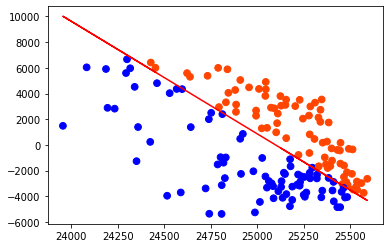

In [ ]:
# Podemos ver o resultado dessa classificação simples visualmente:
col = np.where(N < 0, 'b', '#ff4500').reshape(-1)

plt.scatter(A_2[:,0], A_2[:,1], c=col, s=45)

plt.plot(A_2[:, 0], -(a*A_2[:, 0] + c) / b, 'r')

# Pontos laranjas são as mulheres e pontos azuis são os homens.
plt.show()

Podemos adicionar essa informação na matriz $A_2$ que tínhamos:
Uma terceira coluna que, se for igual a $-1$, temos que a imagem daquela linha representa um homem. Se for igual a $1$, a imagem daquela linha representa uma mulher

In [ ]:
sexo = np.where(N < 0, -1, 1).reshape((160, 1))

final = np.hstack([A_2, sexo])
# printando apenas as 5 primeiras linhas/imagens
print(final[:5, :])

[[ 2.51292035e+04 -3.27656415e+03 -1.00000000e+00]
 [ 2.53639461e+04 -9.72982019e+02  1.00000000e+00]
 [ 2.52506282e+04 -3.88872601e+03 -1.00000000e+00]
 [ 2.52813673e+04 -6.32242353e+02  1.00000000e+00]
 [ 2.50528484e+04 -3.32845354e+03 -1.00000000e+00]]
